# MNIST 手寫數字辨識資料集介紹 & CNN


### STEP1. 匯入 Keras 及相關模組 

首先匯入 Keras 及相關模組: 

In [1]:
import numpy as np
import pandas as pd
from keras.utils import np_utils  # 用來後續將 label 標籤轉為 one-hot-encoding
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices()) # 查看硬體資源
np.random.seed(10)

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12674849858323397874
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10968950375
locality {
  bus_id: 1
}
incarnation: 6899834422734568403
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1"
]


### STEP2. 下載 mnist 資料

下載 Mnist 資料 
我們將建立以下 Keras 程式, 下載並讀取 mnist 資料. 

Mnist 資料的下載路徑在 ~/.keras/datasets/mnist.npz (npz is a simple zip archive, which contains numpy files.) 

In [2]:
from keras.datasets import mnist

### STEP3. 讀取與查看 mnist 資料

In [3]:
(X_train_image, y_train_label), (X_test_image, y_test_label) = mnist.load_data()

print("\t[Info] train data={:7,}".format(len(X_train_image)))  
print("\t[Info] test  data={:7,}".format(len(X_test_image))) 

	[Info] train data= 60,000
	[Info] test  data= 10,000


由上可以知道 training data 共有 60,000 筆; testing data 共有 10,000 筆。

## 查看訓練資料

接著我們來看載入資料的長相與格式.

### STEP1. 訓練資料是由 images 與 labels 所組成

In [4]:
print("\t[Info] Shape of train data=%s" % (str(X_train_image.shape)))
print("\t[Info] Shape of train label=%s" % (str(y_train_label.shape)))

	[Info] Shape of train data=(60000, 28, 28)
	[Info] Shape of train label=(60000,)


訓練資料是由 images 與 labels 所組成共有 60,000 筆, 每一筆代表某個數字的影像為 28x28 pixels.

### STEP2. 定應 plot_image 函數顯示數字影像

In [5]:
import matplotlib.pyplot as plt
def plot_image(image):
    fig = plt.gcf()
    fig.set_size_inches(2, 2)
    plt.imshow(image, cmap='binary') # cmap='binary' 參數設定以黑白灰階顯示
    plt.show()

### STEP3. 執行 plot_image 函數查看第 0 筆數字影像與 label 資料 

以下程式呼叫 plot_image 函數, 傳入 X_train_image[0], 也就是順練資料集的第 0 筆資料, 顯示結果可以看到這是一個數字 5 的圖形: 

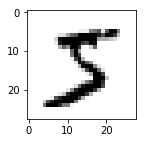

In [6]:
plot_image(X_train_image[0])

In [7]:
y_train_label[0]

5

## 查看多筆訓練資料 images 與 labels

接下來我們將建立 plot_images_labels_predict 函數, 可以顯示多筆資料的影像與 label. 

### STEP1. 建立 plot_images_labels_predict() 函數

因為後續我們希望能很方便查看數字圖形, 真實的數字與預測結果, 所以我們建立了以下函數:

In [8]:
def plot_images_labels_predict(images, labels, prediction, idx, num=10):  
    fig = plt.gcf()  
    fig.set_size_inches(12, 14)  
    if num > 25: num = 25  
    for i in range(0, num):  
        ax=plt.subplot(5,5, 1+i)  
        ax.imshow(images[idx], cmap='binary')  
        title = "label=" + str(labels[idx])  
        if len(prediction) > 0:  
            title = "label={},predict={}".format(str(labels[idx]), str(prediction[idx]))  
        else:  
            title = "label={}".format(str(labels[idx]))  
        ax.set_title(title, fontsize=10)  
        ax.set_xticks([]); ax.set_yticks([])  
        idx+=1  
    plt.show()

### STEP2. 查看訓練資料的前 10 筆資料

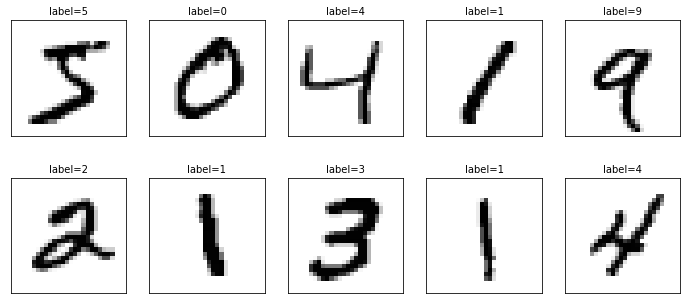

In [9]:
plot_images_labels_predict(X_train_image, y_train_label, [], 0, 10)

## 多層感知器模型資料前處理

接下來我們建立 多層感知器模型 (MLP), 我們必須先將 images 與 labels 的內容進行前處理, 才能餵進去 Keras 預期的資料結構。

### STEP1. features (數字影像的特徵值) 資料前處理

首先將 image 以 reshape 轉換為二維 ndarray 
因正常照片為 RGB 三維度，而這邊只有灰階
而 Conv2D data 需要多一個維度，在此增加
並進行 normalization (Feature scaling): 

In [10]:
x_Train = X_train_image.reshape(60000, 28, 28).astype('float32')
x_Test = X_test_image.reshape(10000, 28, 28).astype('float32')

x_Train = x_Train[:,:,:,np.newaxis] #為了能fit進Conv2d需要多加一個維度
x_Test = x_Test[:,:,:,np.newaxis]

print("\t[Info] xTrain: %s" % (str(x_Train.shape)))
print("\t[Info] xTest: %s" % (str(x_Test.shape)))
  
# Normalization
x_Train_norm = x_Train/255
x_Test_norm = x_Test/255

	[Info] xTrain: (60000, 28, 28, 1)
	[Info] xTest: (10000, 28, 28, 1)


### STEP2. labels (影像數字真實的值) 資料前處理

label 標籤欄位原本是 0-9 數字, 而為了配合 Keras 的資料格式, 我們必須進行 One-hot-encoding 將之轉換為 10 個 0 或 1 的組合, 例如數字 7 經過 One-hot encoding 轉換後是 0000001000, 正好對應到輸出層的 10 個神經元. 下面簡單測試過程:

In [11]:
y_TrainOneHot = np_utils.to_categorical(y_train_label) # 將 training 的 label 進行 one-hot encoding
y_TestOneHot = np_utils.to_categorical(y_test_label) # 將測試的 labels 進行 one-hot encoding

print(y_train_label[0]) # 檢視 training labels 第一個 label 的值
print(y_TrainOneHot[:1]) # 檢視第一個 label 在 one-hot encoding 後的結果, 會在第六個位置上為 1, 其他位置上為 0

5
[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]]


## 建立模型
首先我們使用了兩層 Convolution 卷積層並以 Relu 為 activation function
以及各對應的 Pooling.
再來接上多層感知器 Multilayer Perceptron 模型.
輸出層共有 10 個神經元，以 sonftmax 為 activation function.

### Convolution Layer卷積層 介紹

#### CNN 架構

![](https://cdn-images-1.medium.com/max/1600/1*RIBWK55dcDJa-zI_dFPDnw.png)

卷積運算就是將原始圖片的與特定的Feature Detector(filter)做卷積運算(符號⊗)，卷積運算就是將下圖兩個3x3的矩陣作相乘後再相加，以下圖為例 `0*0 + 0*0 + 0*1+ 0*1 + 1 *0 + 0*0 + 0*0 + 0*1 + 0*1 =0`

![卷積運算](https://cdn-images-1.medium.com/max/800/1*CO0yrGvAE7jw6JfGqCMRPg.png)

#### Feature Detector(Filter)
會隨機產生好幾種(ex:64種)，Feature Detector的目的就是幫助我們萃取出圖片當中的一些特徵(ex:形狀外框)，就像人的大腦在判斷這個圖片是什麼東西也是根據形狀來推測

![](https://cdn-images-1.medium.com/max/1600/1*AJeWQ88UnmfkJ4_sFOT-YA.png)

利用Feature Detector萃取出物體的邊界
![](https://cdn-images-1.medium.com/max/1600/1*MlGDfnY5W0yjA2iHj8K4vg.png)

#### Relu函數去掉負值，更能淬煉出物體的形狀
![](https://cdn-images-1.medium.com/max/1600/1*BZqw3CWuvtc7sNVjgcBPQg.png)

對應代碼:

In [12]:
from keras.models import Sequential  
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
  
model = Sequential()  # Build Linear Model 

#Conv layer 1 output shape (64, 28, 28)
model.add(Conv2D(
    filters=64,
    kernel_size=(5, 5),  # feature detector 的大小 5x5
    padding='same',      # Padding method
    input_shape=(28,28,1),
    activation='relu'
))

# MaxPooling layer1 size (2,2)
model.add(MaxPooling2D(pool_size=(2,2)))

# Conv layer 2 output shape (128, 28, 28)
model.add(Conv2D(
    filters=128,
    kernel_size=(5, 5),
    padding='same',      # Padding method
    activation='relu'
))
model.add(MaxPooling2D(pool_size=(2,2)))

# Drop 掉一些神經元 避免 overfitting
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(units=128, kernel_initializer='normal', activation='relu')) # Add Input/hidden layer
model.add(Dropout(0.3))
model.add(Dense(units=64, input_dim=128, kernel_initializer='normal', activation='relu')) # Add Input/hidden layer  
model.add(Dense(units=10, kernel_initializer='normal', activation='softmax')) # Add Hidden/output layer  
print("\t[Info] Model summary:")  
model.summary()  
print("")

	[Info] Model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       204928    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)             

Summary 的相關說明:
在層跟層之間通常會Drop掉一定比例的神經元來避免Overfit的狀況，要Drop掉多少比例沒有一個特定的值，通常是25%~50%之間

## 進行訓練

當我們建立深度學習模型後, 就可以使用 Backpropagation 進行訓練。

### STEP1. 定義訓練方式

在訓練模型之前, 我們必須先使用 compile 方法, 對訓練模型進行設定, 代碼如下:

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

參數說明如下:
* **loss** : 設定 loss function, 在深度學習通常使用 cross_entropy (Cross entropy) 交叉摘順練效果較好.
* **optimizer** : 設定訓練時的優化方法, 在深度學習使用 adam 可以讓訓練更快收斂, 並提高準確率.
* **metrics** : 設定評估模型的方式是 accuracy (準確率)

### STEP2. 開始訓練
執行訓練的程式碼如下:

In [14]:
train_history = model.fit(x=x_Train_norm, 
                          y=y_TrainOneHot, 
                          validation_split=0.2, 
                          epochs=10, 
                          batch_size=200, 
                          verbose=2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
 - 6s - loss: 0.3546 - acc: 0.8858 - val_loss: 0.0764 - val_acc: 0.9765
Epoch 2/10
 - 4s - loss: 0.0858 - acc: 0.9732 - val_loss: 0.0510 - val_acc: 0.9845
Epoch 3/10
 - 4s - loss: 0.0597 - acc: 0.9820 - val_loss: 0.0451 - val_acc: 0.9863
Epoch 4/10
 - 4s - loss: 0.0461 - acc: 0.9859 - val_loss: 0.0406 - val_acc: 0.9876
Epoch 5/10
 - 4s - loss: 0.0396 - acc: 0.9878 - val_loss: 0.0397 - val_acc: 0.9888
Epoch 6/10
 - 4s - loss: 0.0328 - acc: 0.9893 - val_loss: 0.0335 - val_acc: 0.9905
Epoch 7/10
 - 4s - loss: 0.0284 - acc: 0.9910 - val_loss: 0.0369 - val_acc: 0.9899
Epoch 8/10
 - 4s - loss: 0.0245 - acc: 0.9922 - val_loss: 0.0311 - val_acc: 0.9917
Epoch 9/10
 - 4s - loss: 0.0215 - acc: 0.9932 - val_loss: 0.0350 - val_acc: 0.9913
Epoch 10/10
 - 4s - loss: 0.0189 - acc: 0.9942 - val_loss: 0.0324 - val_acc: 0.9918


上面訓練過程會儲存於 train_history 變數中, 參數說明如下: 

* **x = x_Train_norm** : features 數字的影像特徵值 (60,000 x 784 的陣列)
* **y = y_Train_OneHot** : label 數字的 One-hot encoding 陣列 (60,000 x 10 的陣列)
* **validation_split = 0.2** : 設定訓練資料與 cross validation 的資料比率. 也就是說會有 0.8 * 60,000 = 48,000 作為訓練資料; 0.2 * 60,000 = 12,000 作為驗證資料.
* **epochs** = 10 : 執行 10 次的訓練週期.
* **batch_size = 200** : 每一批次的訓練筆數為 200
* **verbose = 2** : 顯示訓練過程. 共執行 10 次 epoch (訓練週期), 每批 200 筆, 也就是每次會有 240 round (48,000 / 200 = 240). 每一次的 epoch 會計算 accuracy 並記錄在 train_history 中.

### STEP3. 建立 show_train_history 顯示訓練過程

之前訓練步驟會將每一個訓練週期的 accuracy 與 loss 記錄在 train_history 變數. 我們可以使用下面程式碼讀取 train_history 以圖表顯示訓練過程:

In [15]:
import matplotlib.pyplot as plt  
def show_train_history(train_history, train, validation):  
    plt.plot(train_history.history[train])  
    plt.plot(train_history.history[validation])  
    plt.title('Train History')  
    plt.ylabel(train)  
    plt.xlabel('Epoch')  
    plt.legend(['train', 'validation'], loc='upper left')  
    plt.show()

執行結果如下:

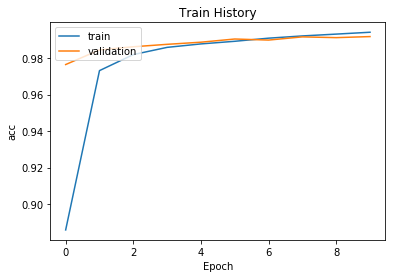

In [16]:
show_train_history(train_history, 'acc', 'val_acc')

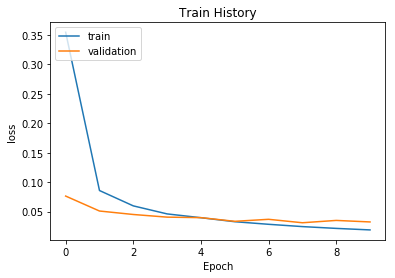

In [17]:
show_train_history(train_history, 'loss', 'val_loss')

總共執行 10 個 Epoch 訓練週期, 可以發現:    
* 不論訓練與驗證, 誤差越來越低.
* 在 Epoch 訓練後期, "loss 訓練的誤差" 比 "val_loss 驗證的誤差" 小.

## 以測試資料評估模型準確率與預測 

我們已經完成訓練模型, 現在要使用 test 測試資料來評估模型準確率。

### STEP1. 評估模型準確率

使用下面代碼評估模型準確率:

In [18]:
scores = model.evaluate(x_Test_norm, y_TestOneHot)  
print()  
print("\t[Info] Accuracy of testing data = {:2.1f}%".format(scores[1]*100.0))

10000/10000 [==============================] - 1s 95us/step

	[Info] Accuracy of testing data = 99.2%


### STEP2. 進行預測
前面我們建立模型並於訓練後達成可以接受的 97% 準確率, 接著我們將使用此模型進行預測。

	[Info] Making prediction to x_Test_norm

	[Info] Show 10 prediction result (From 240):
[5 9 8 7 2 3 0 4 4 2]



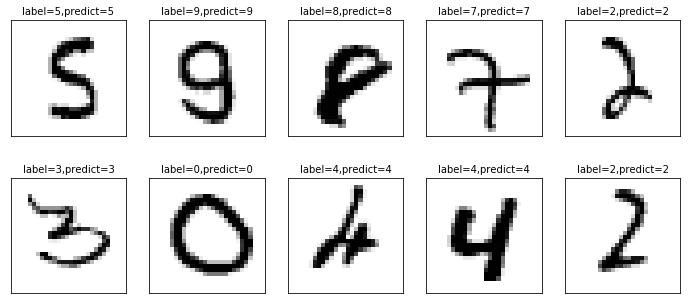

In [19]:
print("\t[Info] Making prediction to x_Test_norm")  
prediction = model.predict_classes(x_Test_norm)  # Making prediction and save result to prediction  
print()  
print("\t[Info] Show 10 prediction result (From 240):")  
print("%s\n" % (prediction[240:250]))  
  
plot_images_labels_predict(X_test_image, y_test_label, prediction, idx=240)

## 總結 (Conclusion)

可以多了解 CNN 的用法，傳入的參數以及各張量的意義。

參考:
* [程式扎記 - MNIST 手寫數字辨識資料集介紹](http://puremonkey2010.blogspot.tw/2017/07/toolkit-keras-mnist-cnn.html)
* [林大貴 - TensorFlow+Keras深度學習人工智慧實務應用](http://tensorflowkeras.blogspot.com)
* [[資料分析&機器學習] 第5.1講: 卷積神經網絡介紹(Convolutional Neural Network)](https://medium.com/@yehjames/%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90-%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92-%E7%AC%AC5-1%E8%AC%9B-%E5%8D%B7%E7%A9%8D%E7%A5%9E%E7%B6%93%E7%B6%B2%E7%B5%A1%E4%BB%8B%E7%B4%B9-convolutional-neural-network-4f8249d65d4f)